In [1]:
# Importando bibliotecas utilizadas
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from math import sqrt, pow
from datetime import datetime
from time import sleep

In [2]:
from scipy.spatial.distance import pdist, squareform

In [2]:
df = pd.read_csv('datasets/c2ds1-2sp.txt', sep='\t')
df.head()

,sample_label,d1,d2
0,c2sp1s1,10.500000,9.000000
1,c2sp1s2,10.567170,9.268445
2,c2sp1s3,8.275320,11.382210
3,c2sp1s4,8.227458,11.377640
4,c2sp1s5,8.179511,11.372110


In [4]:
df3 = pd.read_csv('datasets/monkey.txt', sep='\t')
df3.columns = ['identificador','d1', 'd2']
df3.head()

,identificador,d1,d2
0,monkeyc1g1s1,8.809783,7.611147
1,monkeyc1g1s2,4.110747,11.103186
2,monkeyc1g1s3,4.114710,11.039587
3,monkeyc1g1s4,3.154736,6.743244
4,monkeyc1g1s5,5.972931,7.537982


In [5]:
df3.tail()

,identificador,d1,d2
3995,monkeyc8sp2s3996,-1.60114,14.773205
3996,monkeyc8sp2s3997,-1.57863,14.893001
3997,monkeyc8sp2s3998,-1.55835,15.013389
3998,monkeyc8sp2s3999,-1.54034,15.134325
3999,monkeyc8sp2s4000,-1.52460,15.255768


# Algoritmo

In [ ]:
#Distancia Euclidiana
# Mudei a forma como é calculado para poder utilizar vetorização
def distancia_euclidiana(x1, y1, x2, y2):
    X = x1 - x2
    Y = y1 - y2
    
    X = X*X
    Y = Y*Y
    
    distancia = np.sqrt(X+Y)
    return distancia

In [ ]:
def calcular_distancia_full_optimized(df):
    lista = []
    for i, row in df.iterrows():
        distancias = distancia_euclidiana(row['d1'], row['d2'], df[i+1:]['d1'].values, df[i+1:]['d2'].values)
        
        lista.append(distancias)
      
    return lista

In [ ]:
def dist_matrix(df):
    lista = []
    for i, row in df.iterrows():
        distancias = distancia_euclidiana(row['d1'], row['d2'], df['d1'].values, df['d2'].values)

        lista.append(distancias)
    
    matrix = np.matrix(lista)
    np.fill_diagonal(matrix, float('inf'))
    return matrix

In [ ]:
def get_pos(u, v, num_obj):
    return u*num_obj + v

In [ ]:
def criar_lista_de_indices(pos_menor, pos_maior, numero_de_objetos):
    lista = np.array([], dtype=int)
    for i in pos_menor:
        aux = get_pos(i, pos_maior, numero_de_objetos)
        lista = np.concatenate((lista,aux))
        
    return lista

In [ ]:
def agrupar_clusters(matriz, clusters, objetos, numero_de_objetos):
    obj1, obj2 =  objetos
    cluster1 = clusters[obj1]
    cluster2 = clusters[obj2]
    
    if cluster1 == cluster2:
        return False
    
    if cluster1 < cluster2:
        menor_cluster = cluster1
        maior_cluster = cluster2
    else:
        menor_cluster = cluster2
        maior_cluster = cluster1
        
    pos_menor = np.array(np.where(clusters == menor_cluster))
    pos_maior = np.array(np.where(clusters == maior_cluster))
    
#     print(f"Número de objetos {numero_de_objetos}")
#     print(f"Posição cluster menor {pos_menor}")
#     print(f"Posição cluster maior {pos_maior}\n\n")
#     print(lista_de_indices_inf)
    lista_de_indices_inf = criar_lista_de_indices(pos_menor[0], pos_maior[0], numero_de_objetos)
#     print(f'Lista de índices {lista_de_indices_inf}')
    
    np.put(matriz, lista_de_indices_inf, float('inf'))
    
    clusters[clusters == maior_cluster] = menor_cluster
    return True

In [ ]:
def single_link(dataset, k_min, k_max, nome):
    numero_de_objetos = len(dataset)
    matrix = dist_matrix(dataset)
    clusters = np.arange(numero_de_objetos)
    
    qtd_clusters = numero_de_objetos
    while qtd_clusters > k_min:
        objetos = matrix.argmin()
        i = objetos // numero_de_objetos
        j = objetos % numero_de_objetos
        matrix[i,j] = float('inf')
        matrix[j,i] = float('inf')
        
        if agrupar_clusters(matrix, clusters, [i,j], numero_de_objetos):
            if qtd_clusters % 100 == 0:
                print(qtd_clusters)
            qtd_clusters -= 1
    
    return clusters

# MST

In [3]:
#Distancia Euclidiana
# Mudei a forma como é calculado para poder utilizar vetorização
def distancia_euclidiana(x1, y1, x2, y2):
    X = x1 - x2
    Y = y1 - y2
    
    X = X*X
    Y = Y*Y
    
    distancia = np.sqrt(X+Y)
    return distancia

In [4]:
def dist_matrix(df):
    lista = []
    for i, row in df.iterrows():
        distancias = distancia_euclidiana(row['d1'], row['d2'], df['d1'].values, df['d2'].values)
        
        lista.append(distancias)
    
    matrix = np.array(lista)
    np.fill_diagonal(matrix, float('inf'))
    
    
    return matrix

In [14]:
def agrupar_clusters(clusters, objetos, numero_de_objetos):
    obj1, obj2 =  objetos
    cluster1 = clusters[obj1]
    cluster2 = clusters[obj2]

    
    if cluster1 < cluster2:
        menor_cluster = cluster1
        maior_cluster = cluster2
    else:
        menor_cluster = cluster2
        maior_cluster = cluster1
        
    pos_menor = np.array(np.where(clusters == menor_cluster))
    pos_maior = np.array(np.where(clusters == maior_cluster))

    clusters[clusters == maior_cluster] = menor_cluster

In [23]:
def mst_single_link(matriz, numero_de_objetos):
    # Matriz com objetos e distancia até eles
    # obj1 obj2 dist
    ordem_de_agrupamento = np.zeros((numero_de_objetos-1,3))
    
    # Quais objetos já foram juntados
    conectados = np.zeros(numero_de_objetos)
    
    #Distância até cada objeto que é possível alcançar
    #Seria a distância entres os objetos que já temos como alcançar do algoritmo de Prim
    #Começa todos com infinito
    dist_conhecidas = np.zeros(numero_de_objetos)
    dist_conhecidas[:] = float('inf')
    
    # obj 1 e 2 serão os pontos
    # dist_atual é a menor distância de cada iteração
    obj2 = dist_atual = -1
    obj1 = 0
    
    for i in range(numero_de_objetos-1):
        conectados[obj1] = 1
        dist_atual = float('inf')
        for j in range(numero_de_objetos):
            if conectados[j] == 1:
                continue
                
            dist = matriz[obj1][j]
            if dist_conhecidas[j] > dist:
                dist_conhecidas[j] = dist
            
            
            if dist_conhecidas[j] < dist_atual:
                dist_atual = dist
                obj2 = j
        
        ordem_de_agrupamento[i][0] = obj1
        ordem_de_agrupamento[i][1] = obj2
        ordem_de_agrupamento[i][2] = dist_atual
        obj1 = obj2
        
    return ordem_de_agrupamento[np.argsort(ordem_de_agrupamento[:,2])]
        

In [19]:
def single_link(dataset, k_min, k_max, nome):
    numero_de_objetos = len(dataset)
    matriz = dist_matrix(dataset)
    clusters = np.arange(numero_de_objetos, dtype=int)
    
    qtd_clusters = numero_de_objetos
    ordem_de_agrupamento = mst_single_link(matriz, numero_de_objetos)
    
    for i in range(numero_de_objetos-k_min):
        obj1 = int(ordem_de_agrupamento[i][0])
        obj2 = int(ordem_de_agrupamento[i][1])
        agrupar_clusters(clusters, [obj1,obj2],numero_de_objetos)
    
    return clusters

In [ ]:
%%timeit
clusters_df3 = single_link(df3, 5, 7, 'cu')

Calculou distâncias 0:00:00.626335
Passou do MST 0:00:13.565721
Calculou distâncias 0:00:00.722617
Passou do MST 0:00:14.119054
Calculou distâncias 0:00:00.675359
Passou do MST 0:00:13.475013
Calculou distâncias 0:00:00.617271
Passou do MST 0:00:13.403276
Calculou distâncias 0:00:00.607371
Passou do MST 0:00:13.386076
Calculou distâncias 0:00:00.617382
Passou do MST 0:00:13.490808
Calculou distâncias 0:00:00.617442
Passou do MST 0:00:13.666939
Calculou distâncias 0:00:00.621750


In [24]:
clusters_df = single_link(df, 2, 7, 'cu')

In [25]:
pd.Series(clusters_df).unique()

array([  0, 500])

In [26]:
df['clusters'] = clusters_df
df.head()

,sample_label,d1,d2,clusters
0,c2sp1s1,10.500000,9.000000,0
1,c2sp1s2,10.567170,9.268445,0
2,c2sp1s3,8.275320,11.382210,0
3,c2sp1s4,8.227458,11.377640,0
4,c2sp1s5,8.179511,11.372110,0


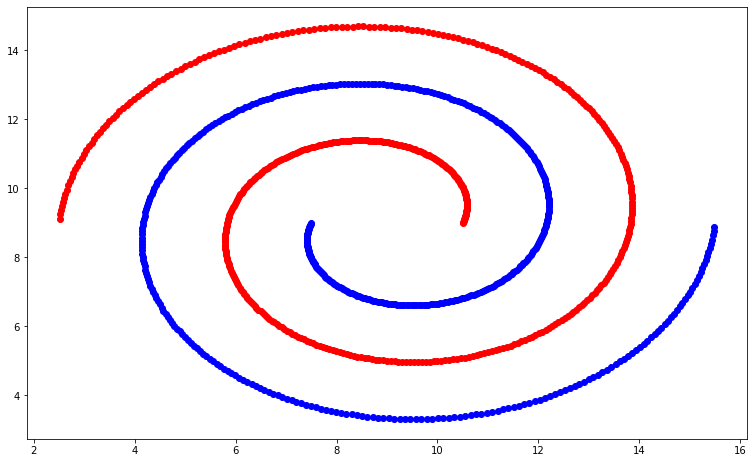

In [27]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])

cores = {0: "red", 500: "blue"}

for i in [0,500]:
    temp = df.query(f'clusters == {i}')
    
    plt.scatter(x=temp['d1'], y=temp['d2'], color=cores[i])

In [ ]:
a = np.array([[1,2,3,0],
              [7,0,9,0]])

a[np.argsort(a[:,1])]


In [ ]:
teste = dist_matrix(df_menor)
teste[0][0]

Após os testes com vetorização ainda ficou muito lento, próximos dos 30min, então fui ler sobre e descobri que a forma mais otimizada do Single Link utiliza algo semelhante ao algoritmo de Prim.

[Link do artigo](http://eprints.hud.ac.uk/id/eprint/32552/1/DWD_Fmurtagh_31.pdf)
[NN-chain](https://en.wikipedia.org/wiki/Nearest-neighbor_chain_algorithm)
[Prim's Algorithm)https://en.wikipedia.org/wiki/Prim%27s_algorithm

# Testes 

In [9]:
df_menor = df[:10].copy()
df_menor

,sample_label,d1,d2
0,c2sp1s1,10.500000,9.000000
1,c2sp1s2,10.567170,9.268445
2,c2sp1s3,8.275320,11.382210
3,c2sp1s4,8.227458,11.377640
4,c2sp1s5,8.179511,11.372110
5,c2sp1s6,8.131500,11.365610
6,c2sp1s7,8.083443,11.358140
7,c2sp1s8,8.035361,11.349700
8,c2sp1s9,7.987270,11.340270
9,c2sp1s10,7.939200,11.329870


In [10]:
clusters = single_link(df_menor, 2, 5, 'teste')

Calculou distâncias 0:00:00.002962
Passou do MST 0:00:00.010949


In [11]:
clusters

array([0, 0, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
teste1 = distancia_euclidiana(10.5,9, df_menor['d1'], df_menor['d2'])
teste1

In [ ]:
np.arange(10, dtype=int)

In [ ]:
condensed_matrix = pdist(df_menor[['d1', 'd2']])
condensed_matrix

In [ ]:
converted_condensed_matrix = squareform(pdist(df_menor[['d1', 'd2']]))
converted_condensed_matrix

In [ ]:
inicio = datetime.now()
clusters = single_link(df3, 5, 10, 'teste')
fim = datetime.now()

## Difrença entre `calcular_distancia_full_optimized` x  `dist_matrix`
Testes sobre a diferença de tempo entre calcular a matriz completa e apenas metade dela

In [ ]:
%%timeit
teste = dist_matrix(df3)


In [ ]:
%%timeit

teste = calcular_distancia_full_optimized(df3)

O ganho de calcular a matriz inteira não é muito relevante, mas temos que considerar que ao calcular a matriz inteira ganhamos um leque muito grande de funções do ```numpy``` que devem ser adicionados as contas ao alterar a implementeção do algoritmo em si

## Colocando inf nas distâncias entre os mesmos clusters

Eu acho que a parte mais está demorando no momento é quando ele pega distâncias que pertencem ao mesmo cluster e com isso tem que realizar várias iterações até achar uma que funcione. Por isso o que vou tentar fazer é já colocar `float('inf')` nas distâncias de mesmo cluster quando ele juntar.

In [ ]:
matriz = dist_matrix(df_menor[:5])
clusters = np.arange(10)

matriz

In [ ]:
lista = np.array([0,5,2])
np.put(matriz, lista, float('inf'))
matriz

In [ ]:
vet1 = np.array([1,2,3,4])
vet2 = np.array((0,0,5,3))

def get_pos(u, v, num_obj):
    return u*num_obj + v


teste = get_pos(vet1, vet2, 5)
teste = list(teste)
teste

In [ ]:
np.put(matriz, teste, float('inf'))
matriz

In [ ]:
def agrupar_clusters_teste(matriz, clusters, objetos, numero_de_objetos):
    obj1, obj2 =  objetos
    cluster1 = clusters[obj1]
    cluster2 = clusters[obj2]
    
    if cluster1 == cluster2:
        return False
    
    if cluster1 < cluster2:
        menor_cluster = cluster1
        maior_cluster = cluster2
    else:
        menor_cluster = cluster2
        maior_cluster = cluster1
        
    pos_menor = np.array(np.where(clusters == menor_cluster))
    pos_maior = np.array(np.where(clusters == maior_cluster))
    
#     print(f"Número de objetos {numero_de_objetos}")
#     print(f"Posição cluster menor {pos_menor}")
#     print(f"Posição cluster maior {pos_maior}\n\n")
#     print(lista_de_indices_inf)
    lista_de_indices_inf = criar_lista_de_indices(pos_menor[0], pos_maior[0], numero_de_objetos)
    print(f'Lista de índices {lista_de_indices_inf}')
    
    np.put(matriz, lista_de_indices_inf, float('inf'))
    
    clusters[clusters == maior_cluster] = menor_cluster
    return True

In [ ]:
matriz = np.zeros((8,8))
clusters = np.array([0,0,0,5,5,5,2,2], dtype=float)
numero_de_objetos = len(clusters)
obj1 = 5
obj2 = 2

agrupar_clusters_teste(matriz, clusters, [obj1,obj2], numero_de_objetos)

In [ ]:
matriz

In [ ]:
teste = sin